# Анализ гравитационной модели внешней торговли

## Постановка задачи

Работа посвящена оцениванию параметров упрощенной версии гравитационной модели внешней торговли России.

Гравитационная модель внешней торговли предложена Тинбергеном в работе 1962 года. Обзор подходов к оцениванию этой модели можно найти в статье Шумилова А.В. «Оценивание гравитационных моделей международной торговли: обзор основных подходов».

Оценивается ограниченная версия гравитационной модели на основе спецификации, предложенной Тинбергеном:

1) рассматриваются торговые потоки (экспорт) России с остальными странами мира по продуктовой группе "электрические машины и оборудование и их части; звукозаписывающие устройства и репродукторовы; телевизионные видеозаписывающие устройства и репродукторы звука, части и принадлежности таких изделий" за период 2019-2021 гг.;

2) вместо меры матрицы расстояний между странами используется дамми-переменная, отвечающую за наличие общей границы у страны и ее торгового партнера.
## Источники данных:

* The World Bank Group https://data.worldbank.org/indicator/NY.GDP.MKTP.CD
* «Ecomod» - вычислительного центра Федерального исследовательского центра "Информатика и управление" РАН. https://ecomod.tech/home

## Цели работы

Используя модели линейной регрессии для пространственной выборки пар торгующих стран и данные об экспорте Российской продукции в страны мира, выяснить ответы на следующие содержательные вопросы:

    1) можно ли утверждать, что торговля интенсивнее происходит между странами, расположенными рядом,
    2) можно ли утверждать, что пандемия повлияла на интенсивность торговли.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.diagnostic as dg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import linearmodels as lm
from linearmodels.iv import compare
from statsmodels.compat import lzip

## Описание данных:

* country – название страны торгового партнера;
* export – величина экспорта, тыс. долл.;
* twenty_one_year – дамми-переменная: twenty_one_year = 1, если данные за 2021 год, иначе twenty_one_year = 0;
* twenty_year – дамми-переменная: twenty_year = 1, если данные за 2020 год, иначе twenty_year = 0;
* GDP – ВВП страны-партнера, долл.;
* GDP_RF – ВВП России, долл.;
* border – дамми-переменная: border = 1, если у страны-партнера и России имеется общая граница, иначе border = 0;
* language – дамми-переменная: language = 1, если у страны-партнера и России имеется общий язык, иначе language = 0;	
* trade_agreement – дамми-переменная: trade_agreement = 1, если страны-партнер и России участвуют в общих торговых соглашениях, иначе language = 0;
* sanctions – дамми-переменная: sanctions = 1, если страна-партнер наложила на Россию санкции, иначе sanctions = 0;
* covid_restrictions – дамми-переменная: covid_restrictions, если страна-партнер закрывала границы во время пандемии COVID-19, иначе covid_restrictions = 0;
* diff_GDP – разница между ВВП этого года и предыдущего года. 

In [2]:
df = pd.read_excel('DATA_export.xlsx')
df

,country,export,twenty_one_year,twenty_year,GDP,GDP_RF,border,language,trade_agreement,sanctions,covid_restrictions,diff_GDP
0,Afghanistan,203534,1,0,1.595210e+10,1.775800e+12,0,0,0,0,1,-1.316687e+09
1,Albania,101544,1,0,1.826004e+10,1.775800e+12,0,0,0,0,1,2.699645e+08
2,Algeria,519623677,1,0,1.679831e+11,1.775800e+12,0,0,0,0,1,2.675822e+10
3,Angola,3792286,1,0,7.254699e+10,1.775800e+12,0,0,0,0,1,1.569003e+10
4,Argentina,2507337,1,0,4.914927e+11,1.775800e+12,0,0,0,0,1,6.322739e+10
...,...,...,...,...,...,...,...,...,...,...,...,...
427,Uzbekistan,174947496,0,0,5.990767e+10,1.693114e+12,0,0,1,0,1,1.660576e+10
428,Viet Nam,14494793,0,0,3.303913e+11,1.693114e+12,0,0,0,0,1,5.393544e+10
429,Yemen,189596,0,0,2.188761e+10,1.693114e+12,0,0,0,0,0,-5.444694e+08
430,Zambia,243663,0,0,2.330867e+10,1.693114e+12,0,0,0,0,0,-5.108531e+09


## Описателтьные статистики выборки:

In [3]:
sum_stat = df.describe().T
sum_stat

,count,mean,std,min,25%,50%,75%,max
export,432.0,3.667247e+07,1.236268e+08,7.000000e+01,1.261042e+05,2.168190e+06,1.566349e+07,1.100403e+09
twenty_one_year,432.0,3.333333e-01,4.719511e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
twenty_year,432.0,3.333333e-01,4.719511e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
GDP,432.0,5.971028e+11,2.300784e+12,1.200634e+09,1.910326e+10,6.528583e+10,3.524500e+11,2.299610e+13
GDP_RF,432.0,1.652412e+12,1.209799e+11,1.488322e+12,1.488322e+12,1.693114e+12,1.775800e+12,1.775800e+12
border,432.0,1.041667e-01,3.058308e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
language,432.0,2.083333e-02,1.429917e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
trade_agreement,432.0,7.638889e-02,2.659273e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
sanctions,432.0,2.430556e-01,4.294257e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
covid_restrictions,432.0,8.333333e-01,3.731101e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Среднестатистический торговый партнер России имеет ВВП = 5,97 x 10^11 долл. США, не имеет с Россией общих границ (объясняется тем, что у России не так много стран-соседей) и общего языка, не состоит в торговых соглашениях с Россией и не накладывал на Россию санкции. Объем торговли со среднестатистическим партнером составляет 3,67 x 10^7 долл. США.

In [4]:
#Страны с общей границей и без общей границы
df_border = df[df['border'] == 1]
df_no_border = df[df['border'] == 0]

In [5]:
#Описательные статистики стран с общей границей
sum_stat_border = df_border.describe().T
sum_stat_border

,count,mean,std,min,25%,50%,75%,max
export,45.0,1.879605e+08,2.943482e+08,2.076816e+06,1.953149e+07,4.200716e+07,1.973179e+08,1.100403e+09
twenty_one_year,45.0,3.333333e-01,4.767313e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
twenty_year,45.0,3.333333e-01,4.767313e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
GDP,45.0,2.953153e+12,6.470269e+12,1.331298e+10,3.887255e+10,1.566179e+11,5.966244e+11,2.299610e+13
GDP_RF,45.0,1.652412e+12,1.222053e+11,1.488322e+12,1.488322e+12,1.693114e+12,1.775800e+12,1.775800e+12
border,45.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
language,45.0,1.333333e-01,3.437758e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
trade_agreement,45.0,2.000000e-01,4.045199e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
sanctions,45.0,6.000000e-01,4.954337e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
covid_restrictions,45.0,9.333333e-01,2.522625e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
#Описательные статистики стран без общей границы
sum_stat_no_border = df_no_border.describe().T
sum_stat_no_border

,count,mean,std,min,25%,50%,75%,max
export,387.0,1.908084e+07,6.488940e+07,7.000000e+01,9.272650e+04,1.294359e+06,8.400168e+06,6.960683e+08
twenty_one_year,387.0,3.333333e-01,4.720148e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
twenty_year,387.0,3.333333e-01,4.720148e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
GDP,387.0,3.231434e+11,6.451760e+11,1.200634e+09,1.850495e+10,6.360507e+10,3.450980e+11,4.223116e+12
GDP_RF,387.0,1.652412e+12,1.209963e+11,1.488322e+12,1.488322e+12,1.693114e+12,1.775800e+12,1.775800e+12
border,387.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
language,387.0,7.751938e-03,8.781670e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
trade_agreement,387.0,6.201550e-02,2.414959e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
sanctions,387.0,2.015504e-01,4.016774e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
covid_restrictions,387.0,8.217054e-01,3.832560e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Исследуемые группы отличаются с точки зрения торговых потоков. Результаты анализа описательных статистик показывают, что объем экспорта российских товаров в приграничные страны в среднем на порядок превышает объем экспорта в страны, не имеющие общих границ с Россией. Стандартное отклонение экспорта также увеличивается на порядок.

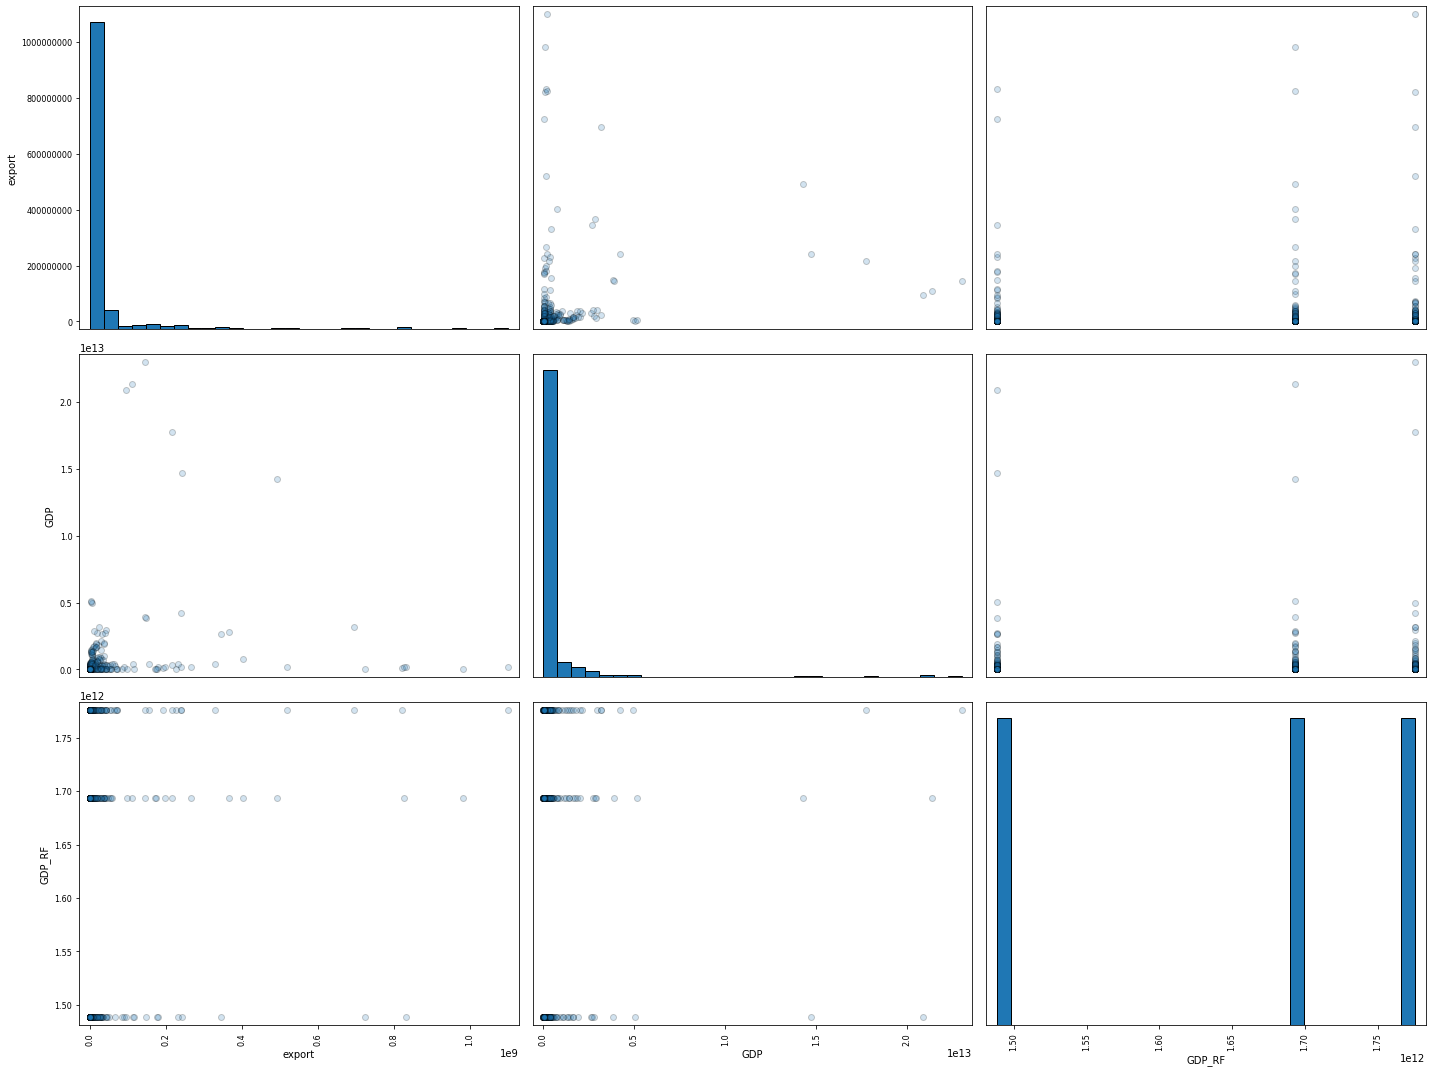

In [7]:
#Визуализация данных
_ = pd.plotting.scatter_matrix(df[['export','GDP','GDP_RF']],
                           alpha = 0.2, figsize = (20, 15), marker = "o",
                           hist_kwds = dict(edgecolor = "black", linewidth = 1, bins = 30),
                           edgecolor = "black")
_ = plt.tight_layout()
plt.show()

## Базовая линейная модель (Модель А):
export = 𝛽0 + 𝛽1GDP + 𝛽1GDP_RF + 𝛽2twenty_one_year + 𝛽4twenty_year + 𝜀

Теоретические требования, предъявляемые в КЛРМ к уравнению, переменным и ошибке, задаются предпосылками теоремы Гаусса-Маркова:
* Модель верно специфицирована;
* Все регрессоры детерминированы и не все равны между собой;
* Ошибки не носят систематического характера;
* Дисперсия ошибок одинакова;
* 𝜀i распределены независимо от 𝜀j при i≠j;
* Дополнительное предположение о нормальном распределении ошибок (не является необходимым условием).

In [8]:
#Линейная спецификация (модель А)
model_A = smf.ols(formula = "export ~ GDP + GDP_RF + twenty_one_year + twenty_year", data = df).fit()
print(model_A.summary())

                            OLS Regression Results                            
Dep. Variable:                 export   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     5.090
Date:                Thu, 27 Apr 2023   Prob (F-statistic):            0.00180
Time:                        23:56:44   Log-Likelihood:                -8654.3
No. Observations:                 432   AIC:                         1.732e+04
Df Residuals:                     428   BIC:                         1.733e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -5.763e+05   1.41e+06     

Модель А может объяснить 3,5% дисперсии зависимой переменной (экспорта). Гипотеза о незначимости регрессии отвергается (p-value = 0,0018). ВВП России и ВВП страны партнера являются значимыми факторами, влияющими на экспорт (при любом стандартном уровне значимости), при этом дамми-переменные, отвечающие за различие по годам, не являются значимыми. Содержательно, это позволяет сделать вывод, что торговля между Россией и торговыми партнерами статистически не меняется с 2019 по 2021 годы.

Интерпретация коэффициентов модели А следующая: при увеличении (уменьшении) ВВП страны-партнера на 1000000 долл. США и при прочих равных условиях, экспорт в эту страну увеличивается (уменьшается) на 9,718 долл. США.

## Выбросы

Cтатистические выбросы можно определить из условий:

* Стьюдентизированные остатки больше двух;
* DFFITS > 2*sqrt(k/n) (2*sqrt(4/432) ≈ 0,2151657);
* Расстояние Кука > k/n (= 4/432);
* DFBETA > 2/sqrt(n) (2/sqrt(432) ≈ 0,096225).

где k - количество регрессоров, n - количество наблюдений

In [9]:
#Таблица с данными + остатки
influence = model_A.get_influence()
resid_student = influence.resid_studentized_external
(cooks, p) = influence.cooks_distance
(dffits, p) = influence.dffits
leverage = influence.hat_matrix_diag

lin_model_res = pd.concat([pd.Series(cooks, name = "cooks"), pd.Series(dffits, name = "dffits"), pd.Series(resid_student, name = "resid_student"), pd.Series(leverage, name = "leverage"), 
                           pd.DataFrame(influence.dfbetas, columns = ['dfb_intercept', 'dfb_GDP', 'dfb_GDP_RF', 'dfb_twenty_one_year', 'dfb_twenty_year'])], axis = 1)

df_res = pd.concat([df, lin_model_res], axis = 1)

In [10]:
# Выбросы: Стьюдентизированные остатки больше двух, DFFITS > 2*sqrt(4/432) (≈ 0.2151657), Расстояние Кука > 4/432, DFBETA > 2/sqrt(432) (≈ 0.096225)

df_res[((df_res['resid_student'] > 2)|(df_res['resid_student'] < -2)) &
       ((df_res['dffits'] > 2*np.sqrt(4/432))|(df_res['dffits'] < -2*np.sqrt(4/432))) &
       (((df_res['dfb_intercept'] > 2/np.sqrt(432))|(df_res['dfb_intercept'] < -2*np.sqrt(432))) |
       ((df_res['dfb_GDP'] > 2/np.sqrt(432))|(df_res['dfb_GDP'] < -2/np.sqrt(432))) |
       ((df_res['dfb_GDP_RF'] > 2/np.sqrt(432))|(df_res['dfb_GDP_RF'] < -2/np.sqrt(432))) |
       ((df_res['dfb_twenty_one_year'] > 2/np.sqrt(432))|(df_res['dfb_twenty_one_year'] < -2/np.sqrt(432))) |
       ((df_res['dfb_twenty_year'] > 2/np.sqrt(432))|(df_res['dfb_twenty_year'] < -2/np.sqrt(432)))) &
       (df_res['cooks'] > 4/432)].sort_values('country')

,country,export,twenty_one_year,twenty_year,GDP,GDP_RF,border,language,trade_agreement,sanctions,...,diff_GDP,cooks,dffits,resid_student,leverage,dfb_intercept,dfb_GDP,dfb_GDP_RF,dfb_twenty_one_year,dfb_twenty_year
2,Algeria,519623677,1,0,1.679831e+11,1.775800e+12,0,0,0,0,...,2.675822e+10,0.022319,0.339976,4.037010,0.007042,-0.116066,-0.040053,0.020562,0.232562,0.001894
11,Belarus,821499502,1,0,6.821882e+10,1.775800e+12,1,1,1,0,...,2.920058e+09,0.059579,0.573855,6.792043,0.007088,-0.195149,-0.081626,0.036528,0.391350,0.003330
155,Belarus,724434328,0,1,6.148959e+10,1.488322e+12,1,1,1,0,...,-6.729228e+09,0.047127,0.504800,5.988095,0.007056,0.428316,-0.063600,-0.046931,0.002312,0.375586
299,Belarus,981785972,0,0,6.440965e+10,1.693114e+12,1,1,1,0,...,8.187554e+09,0.086839,0.710802,8.427886,0.007063,-0.273424,-0.092041,0.705676,-0.510844,-0.466217
314,China,491727111,0,0,1.427994e+13,1.693114e+12,1,0,1,0,...,3.839245e+12,0.148923,0.869663,2.779403,0.089173,-0.102031,0.835114,0.125318,-0.180064,-0.169277
57,India,696068280,1,0,3.173398e+12,1.775800e+12,0,0,1,0,...,1.638643e+11,0.053001,0.531145,5.350708,0.009758,-0.157123,0.285194,-0.018641,0.307037,-0.000900
201,India,344654730,0,1,2.667688e+12,1.488322e+12,0,0,1,0,...,-5.057096e+11,0.010541,0.230895,2.439468,0.008879,0.173435,0.107777,-0.037288,0.000300,0.151800
345,India,366009733,0,0,2.831552e+12,1.693114e+12,0,0,1,0,...,4.704679e+11,0.011786,0.244296,2.540992,0.009159,-0.083869,0.120117,0.192908,-0.154892,-0.142204
65,Kazakhstan,1100402905,1,0,1.908143e+11,1.775800e+12,1,1,1,0,...,1.058481e+10,0.108355,0.811253,9.639505,0.007033,-0.277181,-0.091013,0.048469,0.555283,0.004475
209,Kazakhstan,831469296,0,1,1.710824e+11,1.488322e+12,1,1,1,0,...,-1.973189e+10,0.062099,0.587562,6.991479,0.007013,0.499929,-0.058157,-0.056979,0.002622,0.438349


Обнаружены выбросы для следующих стран: Китай, Турция (в 2019 году), Алжир (в 2021 году); Беларусь, Индия, Казахстан (в 2019 - 2021 годах).

Интерпретируя полученные результаты, можно заметить, что Беларусь и Казахстан имеют с Россией общие границы, общий язык, а также состоят в общих торговых союзах. Китай и Индия состоят с Россией в едином экономическом союзе BRICS. Китай также имеет с Россией общую границу.

In [11]:
#Данные, очищенные от выбросов (без Беларуси, Индии и Казахстана)
df_clean = df.loc[(df['country'] != 'Belarus') &
                 (df['country'] != 'India') &
                 (df['country'] != 'Kazakhstan')]
df_clean

,country,export,twenty_one_year,twenty_year,GDP,GDP_RF,border,language,trade_agreement,sanctions,covid_restrictions,diff_GDP
0,Afghanistan,203534,1,0,1.595210e+10,1.775800e+12,0,0,0,0,1,-1.316687e+09
1,Albania,101544,1,0,1.826004e+10,1.775800e+12,0,0,0,0,1,2.699645e+08
2,Algeria,519623677,1,0,1.679831e+11,1.775800e+12,0,0,0,0,1,2.675822e+10
3,Angola,3792286,1,0,7.254699e+10,1.775800e+12,0,0,0,0,1,1.569003e+10
4,Argentina,2507337,1,0,4.914927e+11,1.775800e+12,0,0,0,0,1,6.322739e+10
...,...,...,...,...,...,...,...,...,...,...,...,...
427,Uzbekistan,174947496,0,0,5.990767e+10,1.693114e+12,0,0,1,0,1,1.660576e+10
428,Viet Nam,14494793,0,0,3.303913e+11,1.693114e+12,0,0,0,0,1,5.393544e+10
429,Yemen,189596,0,0,2.188761e+10,1.693114e+12,0,0,0,0,0,-5.444694e+08
430,Zambia,243663,0,0,2.330867e+10,1.693114e+12,0,0,0,0,0,-5.108531e+09


In [12]:
#Переоценка модели А
model_A_clean = smf.ols(formula = "export ~ GDP + GDP_RF + twenty_one_year + twenty_year", data = df_clean).fit()
print(model_A_clean.summary())

                            OLS Regression Results                            
Dep. Variable:                 export   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     22.75
Date:                Thu, 27 Apr 2023   Prob (F-statistic):           1.16e-13
Time:                        23:56:45   Log-Likelihood:                -8138.7
No. Observations:                 423   AIC:                         1.629e+04
Df Residuals:                     419   BIC:                         1.630e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -4.624e+05   6.47e+05     

R-квадрат увеличился (до 14%) после удаления выбросов.
p-value для гипотезы о незначимости регрессии – уменьшилось.
Значимость регрессора GDP не изменилась, а регрессора GDP_RF незначительно увеличилась.
Согласно полученной оценке, при увеличении (уменьшении) ВВП страны-партнера на 1000000 долл. США и при прочих равных условиях, экспорт в эту страну увеличивается (уменьшается) на 9,475 долл. США.

## Тест Чоу

Для диагностики неоднородности выборки проводится тест Чоу. В нем проверяется статистическое разлилие оценок модели для наблюдений с border = 1 и с border = 0

In [13]:
model_border = smf.ols(formula = "export ~ GDP + GDP_RF + twenty_one_year + twenty_year", data = df_border).fit()
model_no_border = smf.ols(formula = "export ~ GDP + GDP_RF + twenty_one_year + twenty_year", data = df_no_border).fit()
model_r = smf.ols(formula = "export ~ GDP + GDP_RF + twenty_one_year + twenty_year", data = df).fit()

RSS_border = model_border.ssr
RSS_no_border = model_no_border.ssr
RSS_r = model_r.ssr

n = len(df.export)
num = (RSS_r - (RSS_border + RSS_no_border))/5
den = (RSS_border + RSS_no_border)/(n - 2*5)

T_obs  = num/den

sl = 0.01
T_cr = stats.f.ppf(1 - sl, 5, n - 2*5)

print("T_obs:", abs(T_obs))
print("T_cr:", T_cr)
print("p-value:", (1 - stats.f.cdf(abs(T_obs),5, n - 2*5)))

if T_obs > T_cr:
    print("Отклонение нулевой гипотезы: следует оценивать регрессию по подгруппам")
else:
    print("Нулевая гипотеза не отклоняется: выборка однородна")

T_obs: 19.47191781343937
T_cr: 3.06080842548784
p-value: 1.1102230246251565e-16
Отклонение нулевой гипотезы: следует оценивать регрессию по подгруппам


## Оценкa модели с учетом общих границ:

export = 𝛽0 + 𝛽1GDP + 𝛽1GDP_RF + 𝛽2twenty_one_year + 𝛽4twenty_year + 𝛽5border + 𝜀

In [14]:
model_A_border = smf.ols(formula = "export ~ GDP + GDP_RF + twenty_one_year + twenty_year + border", data = df_clean).fit()
print(model_A_border.summary())

                            OLS Regression Results                            
Dep. Variable:                 export   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     22.55
Date:                Thu, 27 Apr 2023   Prob (F-statistic):           7.05e-17
Time:                        23:56:45   Log-Likelihood:                -8129.3
No. Observations:                 423   AIC:                         1.627e+04
Df Residuals:                     418   BIC:                         1.629e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -5.181e+05   6.34e+05     

R-квадрат увеличился (до 17,7%). Все регрессоры с предыдущих итераций остались значимыми. Появилась новая значимая переменная – общие границы России со страной-импортером.

При увеличении (уменьшении) ВВП страны-партнера на 1000000 долл. США и при неизменных других регрессорах, экспорт в эту страну увеличивается (уменьшается) на 7,403 долл. США. При изменении ВВП России на 1000000 долл. США, экспорт изменяется на 9,137 долл. США. Наличие общей границы с торговым партнером увеличивает экспорт в эту страну в среднем на 4,29*107 долл. США.

## Тесты на пропущенные и лишние переменные:

In [15]:
#Тест Рамсея для модели А + граница
RESET1 = dg.linear_reset(model_A_border, power=2, test_type='fitted', use_f = True)
print('Тест Рамсея: p-value', np.round(RESET1.pvalue, 6))
if RESET1.pvalue > 0.05:
    print("Нет оснований отвергнуть гипотезу об отсутствии существенных пропущенных переменных")
else:
    print("Пропущены существенные переменные")

Тест Рамсея: p-value 0.686793
Нет оснований отвергнуть гипотезу об отсутствии существенных пропущенных переменных


C:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


In [16]:
#Тест на лишние переменные для модели А + граница: VIF > 10 => переменная лишняя
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices("export ~ GDP + GDP_RF + twenty_one_year + twenty_year + border", data = df_clean, return_type = "dataframe")
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

C:\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,variable
0,0.000000,Intercept
1,1.175135,GDP
2,inf,GDP_RF
3,inf,twenty_one_year
4,inf,twenty_year
5,1.174933,border


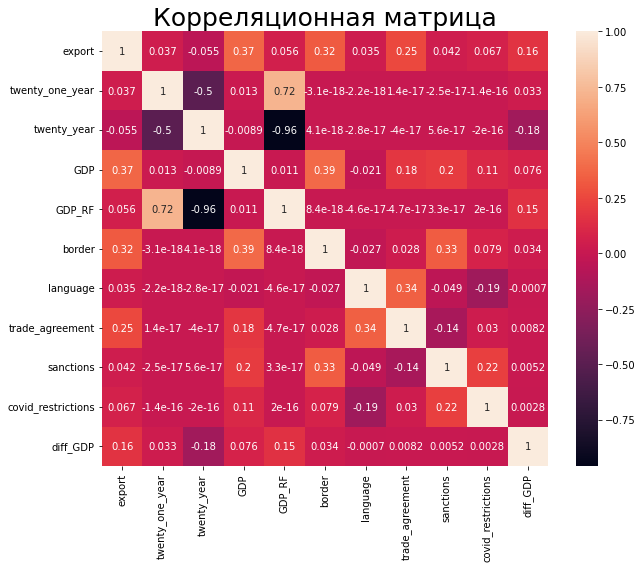

In [17]:
#Корреляционная матрица (коррелированность регрессоров модели А)
fig = plt.figure(figsize = (10, 8))
_ = plt.title('Корреляционная матрица', size = 25)
_ = sns.heatmap(df_clean.corr(), annot = True)
_ = plt.ylim((len(df_clean.corr()), 0))
plt.show()

Коэффициенты вздутия дисперсии для переменных GDP_RF, twenty_one_year, twenty_year больше 10. Таким образом, между данными регрессорами наблюдается сильная мультиколлинеарность. Наличие сильной взаимосвязи между переменными GDP_RF, twenty_one_year и twenty_year подтверждает также корреляционная матрица регрессоров.

## Логарифмическая модель (Модель B):

Далее будет использоваться логарифмическая спецификация гравитационной модели:

log(export) = 𝛽0 + 𝛽1log(GDP) + 𝛽1log(GDP_RF) + 𝛽2twenty_one_year + 𝛽4twenty_year + 𝛽4border + 𝜀

In [18]:
model_B = smf.ols(formula = "np.log(export) ~ np.log(GDP) + np.log(GDP_RF) + twenty_one_year + twenty_year + + border", data = df_clean).fit()
print(model_B.summary())

                            OLS Regression Results                            
Dep. Variable:         np.log(export)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     70.58
Date:                Thu, 27 Apr 2023   Prob (F-statistic):           1.23e-45
Time:                        23:56:45   Log-Likelihood:                -986.99
No. Observations:                 423   AIC:                             1984.
Df Residuals:                     418   BIC:                             2004.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0126      0.002     

Интерпретировать полученные оценки необходимо таким образом:
* Увеличение ВВП страны-партнера на 1% при прочих равных условиях ведет к увеличению экспорта в эту страну в среднем на 0,92%;
* Увеличение ВВП России на 1% при прочих равных условиях снижает экспорт в среднем на 0,34%;
* Наличие общей границы с торговым партнером увеличивает экспорт в эту страну в среднем на 2,78%;
* Года остаются незначимыми переменными.
R-квадрат в логарифмической спецификации увеличивается до 0,403, однако, это не может однозначно свидетельствовать об улучшении объяснительной силы логарифмической модели по сравнению с линейной.

C:\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


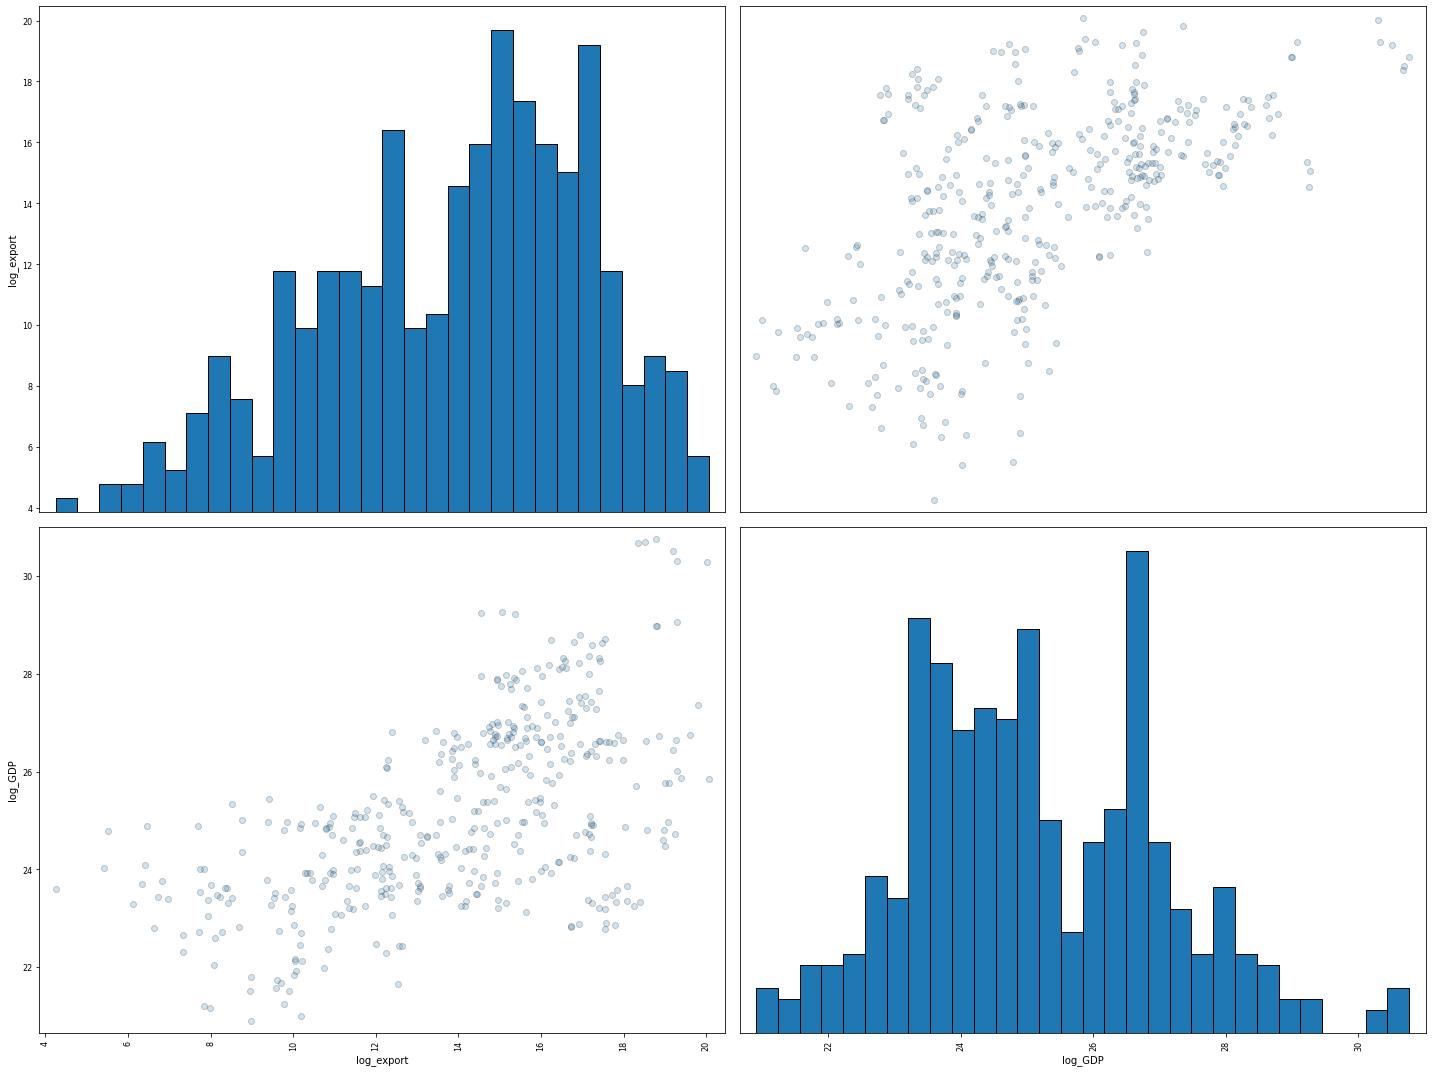

In [19]:
#Визуализация данных для логарифмов
df_clean.loc[:, 'log_export'] = np.log(df_clean['export'])
df_clean.loc[:, 'log_GDP'] = np.log(df_clean['GDP'])

_ = pd.plotting.scatter_matrix(df_clean[['log_export','log_GDP']],
                           alpha = 0.2, figsize = (20, 15), marker = "o",
                           hist_kwds = dict(edgecolor = "black", linewidth = 1, bins = 30),
                           edgecolor = "black")
_ = plt.tight_layout()

plt.show()

## Тест Бокса-Кокса:

Для проверки утверждения, что логарифмическая спецификация более адекватно объясняет дисперсию зависимой переменной (экспорта) используется тест Бокса-Кокса.

In [20]:
#Среднее геометрическое
def g_mean(x):
    a = np.log(x)
    
    return np.exp(a.mean())

#Cоздаем массивы для каждого из трех годов
X_nineteen = df_clean.loc[(df_clean['twenty_one_year'] == 0) & (df_clean['twenty_year'] == 0)]
X_twenty = df_clean.loc[(df_clean['twenty_one_year'] == 0) & (df_clean['twenty_year'] == 1)]
X_twenty_one = df_clean.loc[(df_clean['twenty_one_year'] == 1) & (df_clean['twenty_year'] == 0)]

#Добавляем среднее геометрическое экспорта
X_nineteen['geom'] = g_mean(X_nineteen['export'])
X_twenty['geom'] = g_mean(X_twenty['export'])
X_twenty_one['geom'] = g_mean(X_twenty_one['export'])

#Нормируем экспорт на среднее геометрическое
X_geom = pd.concat([X_nineteen, X_twenty, X_twenty_one])
X_geom['Y_normed'] = X_geom['export']/X_geom['geom']

#Оцениваем две модели
model1 = smf.ols(formula = "Y_normed ~ GDP + GDP_RF + twenty_one_year + twenty_year + border", data = X_geom).fit()
model2 = smf.ols(formula = "np.log(Y_normed) ~ GDP + GDP_RF + twenty_one_year + twenty_year + border", data = X_geom).fit()

RSS_lin = model1.ssr
RSS_log = model2.ssr

BC = (len(df_clean.export)/2)*abs(np.log(RSS_log/RSS_lin))

print('RSS линейной модели: RSS_lin = ', RSS_lin)
print('RSS логарифмической модели: RSS_log = ', RSS_log)
print('Cтатистика Бокса-Кокса: BC = ', BC)
print('Критическое значение статистики Бокса-Кокса: BCсr = 3.84')

if ((BC > 3.84)&(RSS_lin < RSS_log)):
    print("BC > BCсr => между моделями есть значимое различие: выбираем линейную спецификацию")
elif ((BC > 3.84)&(RSS_lin >= RSS_log)): 
    print("BC > BCсr => между моделями есть значимое различие: выбираем логарифмическую спецификацию")
else:
    print("BC < BCсr => vежду моделями нет значимого различия")

RSS линейной модели: RSS_lin =  953092.8812378666
RSS логарифмической модели: RSS_log =  3762.568269590118
Cтатистика Бокса-Кокса: BC =  1170.57013898186
Критическое значение статистики Бокса-Кокса: BCсr = 3.84
BC > BCсr => между моделями есть значимое различие: выбираем логарифмическую спецификацию


C:\Temp/ipykernel_31968/3328798998.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_nineteen['geom'] = g_mean(X_nineteen['export'])
C:\Temp/ipykernel_31968/3328798998.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_twenty['geom'] = g_mean(X_twenty['export'])
C:\Temp/ipykernel_31968/3328798998.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

## Проверка нормальности остатков:

Для проверки остатков логарифмической спецификации на нормальность используется тест Харке-Бера.

Тест Харке-Бера: хи-квадрат 6.259027
Тест Харке-Бера: p-value 0.043739
Остатки распределены нормально


<AxesSubplot:ylabel='Density'>

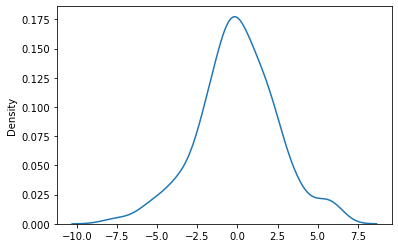

In [21]:
JB_log = stats.jarque_bera(model_B.resid)
print('Тест Харке-Бера: хи-квадрат', np.round(JB_log.statistic, 6))
print('Тест Харке-Бера: p-value', np.round(JB_log.pvalue, 6))
if JB_log.pvalue < 0.05:
    print("Остатки распределены нормально")
else:
    print("Распределение остатков не является нормальным")
    
sns.kdeplot(np.array(model_B.resid))

## Добавление в модель дополнительных дамми-переменных:

Далее для оценки будет использована следующая спецификация:

log(export) = 𝛽0 + 𝛽1log(GDP) + 𝛽2border + 𝛽3sanctions + 𝛽4language + 𝛽5trade_agreement + 𝛽6covid_restrictions + 𝜀

In [22]:
model_B_dummy = smf.ols(formula = "np.log(export) ~ np.log(GDP) + border + sanctions + language + trade_agreement + covid_restrictions", data = df_clean).fit()
print(model_B_dummy.summary())

                            OLS Regression Results                            
Dep. Variable:         np.log(export)   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     58.20
Date:                Thu, 27 Apr 2023   Prob (F-statistic):           4.09e-52
Time:                        23:56:46   Log-Likelihood:                -967.23
No. Observations:                 423   AIC:                             1948.
Df Residuals:                     416   BIC:                             1977.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -8.4543      1

R-квадрат в более полном варианте модели В увеличился до 45,6%.
* Увеличение ВВП страны-партнера на 1% при прочих равных условиях ведет к увеличению экспорта в эту страну в среднем на 0,86%;
* Наличие общей границы с торговым партнером при прочих равных условиях увеличивает экспорт в эту страну в среднем на 2,56%;
* Наличие общего языка с торговым партнером при прочих равных условиях увеличивает экспорт в эту страну в среднем на 3,88%;
* Наличие санкций на экспорт из России от торгового партнера при прочих равных условиях ведет к увеличению в эту страну в среднем на 0,55%. Данный результат достаточно контринтуитивен. Вероятно, страны, наложившие санкции на экспорт Росии – весомые торговые агенты, поэтому санкции не смогли понизить итоговое значение экспорта. Однако данный перестает быть значимым на уровне значимости 5%;
* Ковидные ограничения не являются значимой переменной.

In [23]:
#Мультиколлинеарность в дополненной модели В
y, X = dmatrices("np.log(export) ~ np.log(GDP) + np.log(GDP_RF) + sanctions + language + trade_agreement + covid_restrictions", data = df_clean, return_type = "dataframe")
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,142229.325398,Intercept
1,1.374738,np.log(GDP)
2,1.000789,np.log(GDP_RF)
3,1.306990,sanctions
4,1.202832,language
5,1.210821,trade_agreement
6,1.168289,covid_restrictions


Мультиколлинеарность в данной спецификации модели отсутствует

## Проверка гетероскедостичности:
Для диагностики гетероскедастичности в логарифмической модели были проведены тесты Уайта и Бройша-Пагана.

In [24]:
#тест Уайта
white_test = dg.het_white(model_B_dummy.resid , model_B_dummy.model.exog)
outputs_white = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
lzip(outputs_white, white_test)

[('Test Statistic', 43.50660365614766),
 ('Test Statistic p-value', 0.00013132050636140892),
 ('F-Statistic', 3.1106712015980937),
 ('F-Test p-value', 8.0262261095521e-05)]

In [25]:
#тест Бройша-Пагана
outputs_breusch = ['Lagrange multiplier statistic', 'p-value',
 'f-value', 'f p-value']
breusch = sms.het_breuschpagan(model_B_dummy.resid , model_B_dummy.model.exog)
lzip(outputs_breusch, breusch)

[('Lagrange multiplier statistic', 19.90667072525109),
 ('p-value', 0.002877325569096713),
 ('f-value', 3.4240106117211337),
 ('f p-value', 0.0026054868467587575)]

Оба теста показали наличие гетероскедастичности: p-value = 6,2x10^-4 для теста Уайта и p-value = 2,61x10^-3 для теста Бройша-Пагана. Для коррекции гетероскедастичности модель необходимо переоценить с использованием робастных стандартных ошибок.

In [26]:
#Коррекция гетероскедостичности в модели С
model_B_HC = model_B_dummy.get_robustcov_results(cov_type='HC3')
print(model_B_HC.summary())

                            OLS Regression Results                            
Dep. Variable:         np.log(export)   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     143.4
Date:                Thu, 27 Apr 2023   Prob (F-statistic):           5.11e-98
Time:                        23:56:47   Log-Likelihood:                -967.23
No. Observations:                 423   AIC:                             1948.
Df Residuals:                     416   BIC:                             1977.
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -8.4543      1

## Эндогенность

Основными причинами эндогенности регрессоров могут быть: 

* пропуски существенных переменных; 
* ошибки измерения регрессоров; 
* одновременность; 
* самоотбор; 
* автокорреляция ошибок при наличии в уравнении лага зависимой переменной.

В оцениваемой модели потенциально могут возникнуть проблемы пропуска существенной переменной  и одновременности, так как в расчет ВВП включаются данные по экспорту.

Для коррекции эндогенности ВВП стран-партнеров используется инструментальная переменная log|diff_GDP|, которая считается как логарифм разницы текущего ВВП и ВВП предыдущего года. 

Метод коррекции - двухэтапный МНК

In [27]:
#Коррекция эндогенности (инструмент - log|diff_GDP|)
df_clean.loc[:, 'Intercept'] = 1
iv_result = lm.IV2SLS(df_clean['log_export'], df_clean[['Intercept', 'border', 'sanctions', 'language', 'trade_agreement', 'covid_restrictions']], df_clean['log_GDP'], np.log(abs(df_clean.diff_GDP))).fit(cov_type="robust")
print(iv_result)

                          IV-2SLS Estimation Summary                          
Dep. Variable:             log_export   R-squared:                      0.4563
Estimator:                    IV-2SLS   Adj. R-squared:                 0.4485
No. Observations:                 423   F-statistic:                    1026.2
Date:                Thu, Apr 27 2023   P-value (F-stat)                0.0000
Time:                        23:56:47   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -8.5937     2.0649    -4.1619     0.0000     -12.641     -4.5466
border              

C:\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [28]:
#проверка релевантности инструмента
test_instrument = smf.ols(formula = "np.log(GDP) ~ np.log(abs(diff_GDP))", data = df_clean).fit()
print('Регрессия log(GDP) ~ log|diff_GDP|:')
print('F-статистика в гипотезе о незначимости регрессии =', test_instrument.fvalue)
if ((test_instrument.fvalue > 10)):
    print("F-статистика > 10 => инструмент релевантен")
else:
    print("F-статистика < 10 => инструмент нерелевантен")

Регрессия log(GDP) ~ log|diff_GDP|:
F-статистика в гипотезе о незначимости регрессии = 911.6092066188318
F-статистика > 10 => инструмент релевантен


In [29]:
#проверка валидности инструмента
print("cov(log(lag_GDP), IV-2SLS_residuals) = ", np.cov(np.log(abs(df_clean['diff_GDP'])), iv_result.resids)[0][1])

cov(log(lag_GDP), IV-2SLS_residuals) =  -3.333826106172982e-15


In [30]:
#Проверка экзогенности регрессора (тест Хаусмана)
iv_result.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.0110
P-value: 0.9166
Distributed: F(1,415)
WaldTestStatistic, id: 0x24f07a80910

In [31]:
#Проверка экзогенности регрессора (тест Дарбина)
iv_result.durbin()

Durbin test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.0112
P-value: 0.9158
Distributed: chi2(1)
WaldTestStatistic, id: 0x24f07af8e50

Таким образом, log|diff_GDP| является релевантным и валидным (cov[log(lag_GDP), IV-2SLS_residuals] ≈ 0) инструментом для коррекции эндогенности. Однако, тест Хаусмана и тест Дарбина показали, что регрессор log(lag_GDP) является экзогенным, поэтому коррекция не требуется.

# Выводы

В результате исследования было выяснено, что гравитационная модель применима к анализу торговых потоков, так как имеется четкая взаимосвязь между экономическими размерами торгующих стран и объемом торговли между государствами. Однако, вероятно, не совсем корректен анализ экспорта из отдельно взятой страны, в данном случае из России, так как ВВП экспортера принимает всего несколько значений на рассматриваемом временном промежутке, что влечет за собой негативные последствия в оценках коэффициентов регрессии.

Переходя к главным целям исследования, можно сказать, что прослеживается сильная положительная связь общей границы и объема экспорта в соседние страны. Также исследование не выявило значимых изменений торговых потоков из-за пандемии COVID-19 в исследуемой товарной группе. Вывод был сделан исходя из незначимости дамми-переменных, отвечающих за различие между годами, а также незначимости дамми-переменной, отвечающей за ковидные ограничения.